In [71]:
import cv2
import os

def empty_folder(folder):
    # Check if the folder exists
    if not os.path.exists(folder):
        return
    
    # Get the list of files in the folder
    files = os.listdir(folder)
    
    # Loop through the files and remove them
    for file in files:
        file_path = os.path.join(folder, file)
        os.remove(file_path)

def extract_frames(mp4_path, start_frame, end_frame, stride, save_dir='data/mario', size = (64,64)):
    # Open the video file
    video = cv2.VideoCapture(mp4_path)
    empty_folder(save_dir)
    # Get the total number of frames in the video
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Total frames in video:", total_frames)
    # Validate the start and end frame numbers
    if start_frame < 0 or start_frame >= total_frames:
        raise ValueError("Invalid start frame number")
    if end_frame < 0 or end_frame >= total_frames:
        raise ValueError("Invalid end frame number")
    if start_frame > end_frame:
        raise ValueError("Start frame number cannot be greater than end frame number")
    
    # Validate the stride value
    if stride <= 0:
        raise ValueError("Stride value must be greater than zero")
    
    # Set the current frame number to the start frame
    current_frame = start_frame
    
    # List to store the extracted frames
    frames = []
    
    # Loop through the frames and extract the desired frames
    while current_frame <= end_frame:
        # Set the current frame number
        video.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
        
        # Read the frame
        ret, frame = video.read()
        
        # Check if the frame was read successfully
        if not ret:
            raise ValueError("Error reading frame")
        
        # Resize the frame to the specified size
        frame = cv2.resize(frame, size)
        # Save the frame to the save_dir
        cv2.imwrite(os.path.join(save_dir, f"frame_{current_frame}.jpg"), frame)
        # Append the frame to the list
        frames.append(frame)
        
        # Increment the current frame number by the stride
        current_frame += stride
    
    # Release the video file
    video.release()
    
    return frames

In [73]:
start = 400
end = 1000
stride = 200
frames = extract_frames("data/videos/mario_gameplay.mp4", start, end, stride, size=(64,64))

Total frames in video: 69878


Frame number: 1000


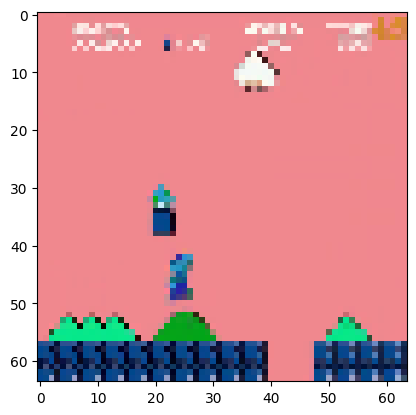

In [64]:
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

i = 33
for i in range(0, len(frames), 1):
    clear_output(wait=True)  # Clear the output of the current cell
    plt.imshow(frames[i])
    print("Frame number:", start + stride * i)
    plt.show()
    time.sleep(0.03)  # Add a 1-second wait time

In [59]:
import torch 
frames = torch.tensor(frames)

In [60]:
frames.shape

torch.Size([301, 64, 64, 3])

In [63]:
#@title 256 dims
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the hyperparameters
batch_size = 32
num_epochs = 100
learning_rate = 0.0005
weight_decay = 0.05  # Increased weight decay
save_interval = 1
accumulation_steps = 2  # Gradient accumulation steps
max_grad_norm = 5.0  # Maximum gradient norm for gradient clipping
save_dir = 'weights'  # Directory to save checkpoints

# Create the save directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the dataset
dataset = ImageFolder(root='data/mario', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Define the autoencoder model with residual connections
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, momentum=0.1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=momentum)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=momentum)
        self.skip_connection = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels, momentum=momentum)
            )

    def forward(self, x):
        residual = self.skip_connection(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            ResidualBlock(3, 64, stride=2),
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 256, stride=2),
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 64 * 32 * 32)
        self.unflatten = nn.Unflatten(1, (64, 32, 32))
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            ResidualBlock(256, 128, stride=1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            ResidualBlock(128, 64, stride=1),
            nn.Upsample(scale_factor=2, mode='nearest'),
            ResidualBlock(64, 64, stride=1),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        latent_space = self.flatten(enc)
        latent_space = self.fc1(latent_space)
        x = self.fc2(latent_space)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x, latent_space

# Perceptual loss using a pre-trained VGG network
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = torchvision.models.vgg16(pretrained=True).features
        self.slice1 = nn.Sequential(*list(vgg.children())[:4]).eval()
        for param in self.slice1.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        x_vgg, y_vgg = self.slice1(x), self.slice1(y)
        loss = nn.functional.l1_loss(x_vgg, y_vgg)
        return loss

def save_model(epoch, model):
    model_path = os.path.join(save_dir, f'model_epoch_{epoch + 1}.pth')
    torch.save(model.state_dict(), model_path)
    print(f'Model saved at epoch {epoch + 1}')

def load_model(model_path):
    model = Autoencoder()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    print(f"Model loaded from {model_path}")
    return model

# Laplacian filter to extract high-frequency components
laplacian_kernel = torch.tensor([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
laplacian_kernel = laplacian_kernel.to(device)

def high_pass_filter(img):
    batch_size, channels, height, width = img.size()
    filtered_img = torch.empty_like(img)
    for i in range(channels):
        filtered_img[:, i:i+1, :, :] = F.conv2d(img[:, i:i+1, :, :], laplacian_kernel, padding=1)
    return filtered_img

def check_for_nans(tensor, name):
    if torch.isnan(tensor).any():
        print(f'NaNs found in {name}')
        return True
    return False

# Training loop with high-frequency emphasis
def train_autoencoder(model, start_epoch=0):
    criterion = nn.L1Loss()
    perceptual_loss = PerceptualLoss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scaler = GradScaler()
    writer = SummaryWriter()

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        for i, (inputs, _) in enumerate(dataloader):
            inputs = inputs.to(device)

            with autocast():
                reconstructed, _ = model(inputs)
                if check_for_nans(reconstructed, 'reconstructed'):
                    return
                high_freq_inputs = high_pass_filter(inputs)
                high_freq_reconstructed = high_pass_filter(reconstructed)
                loss = criterion(reconstructed, inputs) + perceptual_loss(reconstructed, inputs)
                high_freq_loss = criterion(high_freq_reconstructed, high_freq_inputs)
                loss += high_freq_loss
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps

            if i % 10 == 0:
                print(f'Epoch {epoch + 1}, Step {i + 1}/{len(dataloader)}, Loss: {loss.item() * accumulation_steps}')
                writer.add_scalar('Loss/train', loss.item() * accumulation_steps, epoch * len(dataloader) + i)

        avg_loss = running_loss / len(dataloader)
        writer.add_scalar('Loss/epoch', avg_loss, epoch)
        print(f'Epoch {epoch + 1} finished with avg loss: {avg_loss}')

        model.eval()
        with torch.no_grad():
            random_idx = np.random.randint(0, len(dataset))
            random_image = dataset[random_idx][0].unsqueeze(0).to(device)
            reconstructed_image, latent_space = model(random_image)
            writer.add_image('Original Image', (random_image.squeeze(0) + 1) / 2, epoch)
            writer.add_image('Reconstructed Image', (reconstructed_image.squeeze(0) + 1) / 2, epoch)

        if (epoch + 1) % save_interval == 0:
            save_model(epoch, model)

    writer.close()

# Start TensorBoard
%load_ext tensorboard
%tensorboard --logdir=runs

# Initialize and train the model
model = Autoencoder().to(device)
train_autoencoder(model)


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/mcdata2'